# Register & Deploy Model
Register model on UC model registry and deploy it as Model Serving Endpoint

## Env & Variables
Running package install and defining global variables from separate Notebooks.

In [0]:
#%run ./step0_Environment

In [0]:
#%run ./step0_Variables

# LangGraph Agent in Memory
Defining the agent's graph (state, nodes, edges) and run it in memory.

## Env & Variables
Running package install and defining global variables from separate Notebooks.

# Environment Set up
Installing packages and configuring environment.

## Packages Install

Python 3.12.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 2.20.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0.dev0,>=3.19.5, but you have protobuf 6.33.5 which is incompatible.
grpcio-status 1.67.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.33.5 which is incompatible.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-health-checking 1.76.0 requires protobuf<7.0.0,>=6.31.1, but you have protobuf 5.29.6 which is incompatible.
grpcio-tools 1.75.1 requires protobuf<7.0.0,>=6.31.1, but you have protobuf 5.29.6 which is incompatible.
langgraph-a

## Configure Logging

# Global Variables definition
Creating global variables.

# Prompts Definition
Defining all prompts for the nodes and tools used by the agent.

## Assistant Prompt
Prompt used by the Assistant (the "reasoning" node we'll define in the ReAct agent architecture).

## Classification Prompt
Prompt used by the classification tool.

## Schemas
Defining the desired agent's State and output schemas.

## LLMs
Defining the base LLM to be used by the agent nodes.

PyTorch was not found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
Unexpected internal error when monkey patching `PreTrainedModel.from_pretrained`: 
PreTrainedModel requires the PyTorch library but it was not found in your environment. Check out the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.

Unexpected internal error when monkey patching `Trainer.train`: 
Trainer requires the PyTorch library but it was not found in your environment. Check out the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.



## Tools
Specify all tools the agent can use to retrieve information and classify emails.

/local_disk0/.ephemeral_nfs/envs/pythonEnv-08eeb75e-af70-42dc-bab8-722a32c12220/lib/python3.12/site-packages/databricks/connect/session.py:476: UserWarning: Ignoring the default notebook Spark session and creating a new Spark Connect session. To use the default notebook Spark session, use DatabricksSession.builder.getOrCreate() with no additional parameters.
  warnings.warn(new_notebook_session_msg)


## Nodes
Creating the reasoning node (assistant) and the respond node.

## Graph

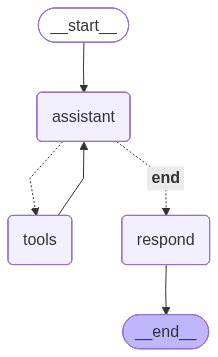

## Testing
Run a test case with Notebook context

'We received from: sofia.rossi@example.com the following email: Understood, thank you.'

================================ Human Message =================================

We received from: sofia.rossi@example.com the following email: Understood, thank you.
================================== Ai Message ==================================

I'll help you classify this email. Let me start by retrieving the customer information and then gather the relevant context.
Tool Calls:
  users__gabriele_albini__classificator_agent_customer_retriever (toolu_bdrk_01VtF7b4aJiV7vD5aqjneEaa)
 Call ID: toolu_bdrk_01VtF7b4aJiV7vD5aqjneEaa
  Args:
    customer_email: sofia.rossi@example.com
================================= Tool Message =================================
Name: users__gabriele_albini__classificator_agent_customer_retriever

{"format": "SCALAR", "value": "Row(Customer_Id=3, Name='Sofia', Surname='Rossi', Email='sofia.rossi@example.com', Address='Via Milano 11, 20126 Milano, Italy')"}
================================== Ai Message ==================================

Now let me retrie

Trace(trace_id=tr-9e20ddc64d47152fc497d630fb7e5732)

customer_details
"List(3, Sofia, Rossi, sofia.rossi@example.com, Via Milano 11, 20126 Milano, Italy)"


order_details
"List(ID-45892183, 2025-11-11, [""Mouse Pad"", ""Ergonomic Wrist Rest""], 42.3, 3)"


ticket_details
"List(3, TKT-004, 2025-11-28 10:48:57, Dear team, I returned an item last week but haven’t received my refund confirmation yet. When should I expect it?, Returns & Refunds)"


In [0]:
%run ./step3_Agent_Graph_inMemory

## Generate py file with Agent code
Register LangGraph agent with model from code, using the `ResponsesAgent` Pyfunc class to wrap the model and deploy it on a Model Serving Endpoint

In [0]:
%%writefile EmailAgent.py

#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# Variable definition
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 

## Variables pointing to Unity Catalog
catalog_ = 'users'
schema_ = 'gabriele_albini'
lakebase_instance_ = 'gabriele-lb'
llm_endpoint = 'databricks-claude-sonnet-4'

Assistant_Prompt = (
  """
    You are a customer support assistant, tasked with classifying incoming emails and suggesting following actions to improve customer relationship.\n\n

    Use the available tools to:\n
    * (When applicable) Retrieve the relevant context information to enrich the customer's email. If the required information to use a tool cannot be obtained or if any retrieval tool generates an error, assume that the related context is not available.\n
    * Classify the email by assigning a label.\n
    * Suggest the next steps.\n\n
    
    *Important*: If the initial request doesn't contain both the sender email address and the email body, return `Others` as final label, DO NOT call any other tool and ask the user to provide the required information.

    Once you've obtained a label for the email, STOP calling tools.
  """)

Classification_Prompt = (
  """
    You are an email dispatcher assistant.\n
    Based on the available context, your tasks are:\n
        (1) Assign a label to the customer's email.\n
        (2) Provide a summarized explanation of why you assigned such label.\n
        (3) Recommend next steps, based on the context.\n\n

    Here are the available labels you can choose from, together with a description of when to use them:\n
    * `Order Issues`: For emails about missing items, wrong orders, delayed shipments, tracking problems or any problem related to orders.\n
    * `Returns & Refunds`: For requests or questions about return procedures, refund status, or exchange policies.\n
    * `Claims & Complaints`: For defect reports, damaged goods, or any service dissatisfaction.\n
    * `Account & Data Requests`: For customers asking to update personal information, manage account settings, or exercise data rights (e.g., GDPR requests).\n
    * `Product Information`: For inquiries about product details, availability, sizing, or compatibility.\n
    * `Payment & Billing`: For issues related to charges, payment methods, invoice requests, or failed transactions.\n
    * `Spam`: for emails that are suspected of being a spam, not referring to any plausible customer's request or follow ups.\n
    * `Others`: for emails that cannot be related to any of the previous labels.\n\n

    Here is the contextual information.\n\n

    The body email sent by the customer:\n
    `{email_body}`\n\n

    The customer's information present in our database:\n
    `{customer_info}`\n\n

    The most recent customer's order present in our database:\n
    `{order_info}`\n\n

    The most recent customer's ticket present in our database:\n
    `{ticket_info}`\n\n

    *IMPORTANT*: Consider the following exceptions when choosing a label:
    * If the email is a follow up to a previous ticket (e.g., the customer is sending a reply; the customer is acknowledging information;), assign the same label as the previous ticket.
    
    Now classify the email, explain your reasoning and recommend next steps.
  """)

#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# Output Schema
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
from pydantic import BaseModel, Field
from typing import Literal

class FinalOutput(BaseModel):
  Customer_Email: str = Field(description = "Email of the customer who sent the message.")
  Customer_Id: str = Field(description = "Id of the customer, related to the email. If not found, return NULL.")
  Customer_Context: str = Field(description = "Summary of all the retrieved information related to the customer's request. If nothing was retrieved, return NULL.")
  Label: Literal[
      "Order Issues",
      "Returns & Refunds",
      "Claims & Complaints",
      "Account & Data Requests",
      "Product Information",
      "Payment & Billing",
      "Spam",
      "Others",
      "Classification Error"] = Field(
    description="Generated label assigned to the email",
    default="Classification Error")
  Rationale: str = Field(description="Reasoning behind the label choice")
  Next_steps: str = Field(description="Recommended action items based on the customer's email")

#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# Graph State
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages, AnyMessage
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

## Set up the agent state to concatenate messages in memory
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    final_output: FinalOutput | None

#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# ResponsesAgent Wrapper for Model Serving
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 

import mlflow
import os
from typing import Generator
from mlflow.pyfunc import ResponsesAgent
from mlflow.types.responses import (
    ResponsesAgentRequest,
    ResponsesAgentResponse,
    ResponsesAgentStreamEvent,
    output_to_responses_items_stream,
    to_chat_completions_input,
)

class EmailClassifierResponsesAgent(ResponsesAgent):
    """
    ResponsesAgent wrapper for the LangGraph email classification agent.
    This enables deployment to Databricks Model Serving with OpenAI-compatible API.
    """
    
    def __init__(self):
        """Initialize the agent. The actual graph will be built in load_context."""
        self.agent = None
        self._is_loaded = False
    
    def load_context(self, context):
        """
        Load the agent when the model is loaded for serving.
        This is NOT called during registration, only when the model is loaded.
        
        Args:
            context: MLflow context (not used but required by interface)
        """
        # Skip loading if already loaded
        if self._is_loaded:
            return
        
        # Enable MLflow tracing for LangGraph
        import mlflow
        mlflow.langchain.autolog()
        
        # Import dependencies here to avoid execution during registration
        from databricks_langchain import ChatDatabricks, UCFunctionToolkit
        from langchain_core.tools import tool
        from langgraph.graph import START, StateGraph, END
        from langgraph.prebuilt import tools_condition, ToolNode
        
        # Base LLM
        model = ChatDatabricks(endpoint=llm_endpoint, temperature=0)
        model_with_output_schema = model.with_structured_output(FinalOutput)
        
        # Classification Tool
        @tool
        def classify_email(customer_info: str, order_info: str, ticket_info: str, email_body: str) -> str:
            """ Classify the customer's email into one of the predefined labels. """
            full_prompt = Classification_Prompt.format(
                email_body=email_body,
                customer_info=customer_info,
                order_info=order_info,
                ticket_info=ticket_info
            )
            result = model.invoke([full_prompt])
            return result.content
        
        # UC functions as Retrieval Tools
        # UCFunctionToolkit automatically handles authentication via passthrough
        toolkit = UCFunctionToolkit(function_names=[
            f"{catalog_}.{schema_}.classificator_agent_customer_retriever",
            f"{catalog_}.{schema_}.classificator_agent_order_retriever",
            f"{catalog_}.{schema_}.classificator_agent_ticket_retriever",
        ])
        uc_tools = toolkit.tools
        
        # Combine tools
        tools = uc_tools + [classify_email]
        model_with_tools = model.bind_tools(tools)
        
        # System message
        sys_msg = SystemMessage(content=Assistant_Prompt)
        
        # Reasoning Node
        def assistant(state: AgentState) -> AgentState:
            result = model_with_tools.invoke([sys_msg] + state["messages"])
            return {"messages": state["messages"] + [result]}
        
        # Respond Node
        def respond(state: AgentState) -> AgentState:
            last_msg = state["messages"][-1]
            result = model_with_output_schema.invoke([HumanMessage(content=last_msg.content)])
            return {"final_output": result}
        
        # Build Graph
        builder = StateGraph(AgentState)
        builder.add_node("assistant", assistant)
        builder.add_node("tools", ToolNode(tools))
        builder.add_node("respond", respond)
        builder.add_edge(START, "assistant")
        builder.add_conditional_edges(
            "assistant",
            tools_condition,
            {"tools": "tools", "__end__": "respond"}
        )
        builder.add_edge("tools", "assistant")
        builder.add_edge("respond", END)
        
        # Compile and store the agent
        self.agent = builder.compile()
        self._is_loaded = True
    
    def predict(self, request: ResponsesAgentRequest) -> ResponsesAgentResponse:
        """
        Synchronous prediction method required by ResponsesAgent.
        Collects all output items from the stream.
        
        Args:
            request: ResponsesAgentRequest containing input messages
            
        Returns:
            ResponsesAgentResponse with output items and custom outputs
        """
        # If agent hasn't been loaded yet, load it
        if not self._is_loaded:
            self.load_context(None)
        
        outputs = [
            event.item
            for event in self.predict_stream(request)
            if event.type == "response.output_item.done"
        ]
        return ResponsesAgentResponse(
            output=outputs,
            custom_outputs=request.custom_inputs
        )
    
    def predict_stream(
        self,
        request: ResponsesAgentRequest,
    ) -> Generator[ResponsesAgentStreamEvent, None, None]:
        """
        Streaming prediction method that yields events as the agent processes.
        
        Args:
            request: ResponsesAgentRequest containing input messages
            
        Yields:
            ResponsesAgentStreamEvent items as the agent processes
        """
        # If agent hasn't been loaded yet, load it
        if not self._is_loaded:
            self.load_context(None)
        
        # Convert ResponsesAgent input format to chat completions format
        cc_msgs = to_chat_completions_input([i.model_dump() for i in request.input])
        
        # Stream the agent execution
        for _, events in self.agent.stream(
            {"messages": cc_msgs},
            stream_mode=["updates"]
        ):
            # Extract messages from each node's output
            for node_data in events.values():
                if "messages" in node_data:
                    # Convert LangGraph messages to ResponsesAgent stream events
                    yield from output_to_responses_items_stream(node_data["messages"])

#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# Set model for code-based logging
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
from mlflow.models import set_model
set_model(EmailClassifierResponsesAgent())

Writing EmailAgent.py


## Register model on MLflow

In [0]:
dbutils.library.restartPython()

In [0]:
%run ./step0_Variables

# Global Variables definition
Creating global variables.

In [0]:
import mlflow
mlflow.langchain.autolog()

# Test the agent locally with tracing enabled
from EmailAgent import EmailClassifierResponsesAgent
agent = EmailClassifierResponsesAgent()
agent.load_context(None)

# Test prediction
test_request = {
    "input": [{
        "role": "user", 
        "content": "We received from: jonas.mueller@example.com the following email: Hi, I received my order today, but one of the items is missing. Could you please check if it will be sent separately?"
    }]
}
agent.predict(test_request)

PyTorch was not found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
Unexpected internal error when monkey patching `PreTrainedModel.from_pretrained`: 
PreTrainedModel requires the PyTorch library but it was not found in your environment. Check out the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.

Unexpected internal error when monkey patching `Trainer.train`: 
Trainer requires the PyTorch library but it was not found in your environment. Check out the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.

/local_disk0/.ephemeral_nfs/envs/pythonEnv-08eeb75e-af70-42dc-bab8-722a32c12220/lib/python3.12/site-packages/databricks/connect/s

ResponsesAgentResponse(tool_choice=None, truncation=None, id=None, created_at=None, error=None, incomplete_details=None, instructions=None, metadata=None, model=None, object='response', output=[OutputItem(type='message', id='lc_run--019c2e26-be66-7481-b949-f45f61e32ed4-0', content=[{'text': "I'll help you classify this email and suggest next steps. Let me first retrieve the relevant customer information and context.", 'type': 'output_text'}], role='assistant'), OutputItem(type='function_call', id='lc_run--019c2e26-be66-7481-b949-f45f61e32ed4-0', call_id='toolu_bdrk_01Epc1TwVNTdGKiZGZ7LJyX8', name='users__gabriele_albini__classificator_agent_customer_retriever', arguments='{"customer_email": "jonas.mueller@example.com"}'), OutputItem(type='function_call_output', call_id='toolu_bdrk_01Epc1TwVNTdGKiZGZ7LJyX8', output='{"format": "SCALAR", "value": "Row(Customer_Id=2, Name=\'Jonas\', Surname=\'M\\u00fcller\', Email=\'jonas.mueller@example.com\', Address=\'221B Baker Street, NW1 6XE London,

Trace(trace_id=tr-225c86a5d330675c5b7fa138816a675f)

In [0]:
import mlflow
from mlflow.models.resources import DatabricksFunction

mlflow.set_tracking_uri("databricks")
mlflow.set_registry_uri("databricks-uc")
uc_model_name = f"{catalog_}.{schema_}.EmailClassifier_agent"

# Declare UC function dependencies for automatic authentication passthrough
uc_function_resources = [
    DatabricksFunction(function_name=f"{catalog_}.{schema_}.classificator_agent_customer_retriever"),
    DatabricksFunction(function_name=f"{catalog_}.{schema_}.classificator_agent_order_retriever"),
    DatabricksFunction(function_name=f"{catalog_}.{schema_}.classificator_agent_ticket_retriever"),
]

with mlflow.start_run() as run:
    # Log the model using code-based logging (EmailAgent.py contains set_model())
    model_info = mlflow.pyfunc.log_model(
        artifact_path="EmailClassifier_agent",
        python_model="EmailAgent.py",
        code_paths=["EmailAgent.py"],
        registered_model_name=uc_model_name,
        resources=uc_function_resources,
        pip_requirements=[
            "databricks-agents==1.9.3",
            "databricks-langchain==0.14.0",
            "databricks-sdk==0.82.0",
            "langchain-community==0.4.1",
            "langchain-core==1.2.7",
            "langchain-openai==1.1.7",
            "langgraph==1.0.7",
            "langgraph-checkpoint==4.0.0",
            "langgraph-prebuilt==1.0.7",
            "mlflow==3.9.0",
            "mlflow-skinny==3.9.0",
            "mlflow-tracing==3.9.0",
            "pydantic==2.12.5",
            "transformers==5.0.0",
            "typing_extensions==4.15.0",
        ],
    )
    
print(f"✅ Model registered successfully: {uc_model_name}")
print(f"📦 Model version: {model_info.registered_model_version}")
print(f"\n🔐 UC Function dependencies declared for automatic authentication:")
for resource in uc_function_resources:
    print(f"  - {resource.name}")
print(f"\n💡 When deployed to Model Serving, the endpoint will automatically have access to these UC functions.")
print(f"   No manual authentication configuration needed!")

2026/02/05 14:14:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/ae9d3dd191e64fcab40794fad2273a0b/models/m-6cff9afa2dff4be4960e0f9f30a10e14?o=1444828305810485
2026/02/05 14:14:16 INFO mlflow.pyfunc: Predicting on input example to validate output
2026/02/05 14:14:17 WARNING mlflow.tracing.fluent: Failed to start span predict_stream: 'NonRecordingSpan' object has no attribute 'context'. For full traceback, set logging level to debug.
2026/02/05 14:14:17 WARNING mlflow.tracing.fluent: Failed to start span LangGraph: 'NonRecordingSpan' object has no attribute 'context'. For full traceback, set logging level to debug.
2026/02/05 14:14:25 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - databricks-sdk (current: 0.85.0, required: databricks-sdk==0.82.0)
 - langchain-core (

Uploading artifacts:   0%|          | 0/13 [00:00<?, ?it/s]

🔗 Created version '9' of model 'users.gabriele_albini.emailclassifier_agent': https://e2-demo-field-eng.cloud.databricks.com/explore/data/models/users/gabriele_albini/emailclassifier_agent/version/9?o=1444828305810485


✅ Model registered successfully: users.gabriele_albini.EmailClassifier_agent
📦 Model version: 9

🔐 UC Function dependencies declared for automatic authentication:
  - users.gabriele_albini.classificator_agent_customer_retriever
  - users.gabriele_albini.classificator_agent_order_retriever
  - users.gabriele_albini.classificator_agent_ticket_retriever

💡 When deployed to Model Serving, the endpoint will automatically have access to these UC functions.
   No manual authentication configuration needed!


In [0]:
from databricks import agents
import mlflow

model_version = model_info.registered_model_version
endpoint_name = f"EmailClassifier_agent_endpoint"

## Set experiment
mlflow.set_experiment('/Shared/email_classifier_traces') ## Customize traces location
mlflow.langchain.autolog()

## Deploy Agent (using agents.deploy() ensures MLflow traces integration)
agents.deploy(
  model_name = f"{catalog_}.{schema_}.EmailClassifier_agent",
  model_version=model_version,
  name=endpoint_name,
  scale_to_zero=True)

/local_disk0/.ephemeral_nfs/envs/pythonEnv-08eeb75e-af70-42dc-bab8-722a32c12220/lib/python3.12/site-packages/databricks/agents/deployments.py:641: UserWarning: This endpoint is being deployed without a feedback model, which has been deprecated.
For more information, see: https://docs.databricks.com/aws/en/generative-ai/agent-framework/feedback-model
  warnings.warn(



    Deployment of users.gabriele_albini.EmailClassifier_agent version 9 initiated.  This can take up to 15 minutes and the Review App & Query Endpoint will not work until this deployment finishes.

    View status: https://e2-demo-field-eng.cloud.databricks.com/ml/endpoints/agents_users-gabriele_albini-EmailClassifier_agent/?o=1444828305810485
    Review App: https://e2-demo-field-eng.cloud.databricks.com/ml/review-v2/3196095f361142908b89ec3961c3c0ff/chat?o=1444828305810485

You can refer back to the links above from the endpoint detail page at https://e2-demo-field-eng.cloud.databricks.com/ml/endpoints/agents_users-gabriele_albini-EmailClassifier_agent/?o=1444828305810485.

To set up monitoring for your deployed agent, see:
https://docs.databricks.com/aws/en/mlflow3/genai/eval-monitor/production-monitoring


Deployment(model_name='users.gabriele_albini.EmailClassifier_agent', model_version='9', endpoint_name='agents_users-gabriele_albini-EmailClassifier_agent', served_entity_name='users-gabriele_albini-EmailClassifier_agent_9', query_endpoint='https://e2-demo-field-eng.cloud.databricks.com/serving-endpoints/agents_users-gabriele_albini-EmailClassifier_agent/served-models/users-gabriele_albini-EmailClassifier_agent_9/invocations?o=1444828305810485', endpoint_url='https://e2-demo-field-eng.cloud.databricks.com/ml/endpoints/agents_users-gabriele_albini-EmailClassifier_agent/?o=1444828305810485', review_app_url='https://e2-demo-field-eng.cloud.databricks.com/ml/review-v2/3196095f361142908b89ec3961c3c0ff/chat?o=1444828305810485')